## ch02 Dataset
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.18</div>
<div style="text-align: right"> Last update: 2023.7.18</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

### Cleanup

In [2]:
import urllib.request
import zipfile

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
def extract_zip(src, dst, member_name):
    """Extract a member file from a zip file and read it into a pandas 
    DataFrame.

    Parameters:
        src (str): URL of the zip file to be downloaded and extracted.
        dst (str): Local file path where the zip file will be written.
        member_name (str): Name of the member file inside the zip file 
            to be read into a DataFrame.

    Returns:
        pandas.DataFrame: DataFrame containing the contents of the 
            member file.
    """   
    url = src
    fname = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode = 'wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name))
        raw = kag.iloc[1:]
        return raw

In [5]:
raw = extract_zip(url, fname, member_name)
raw.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


In [6]:
raw.shape

(23859, 395)

### Cleanup Pipeline

다음 컬럼을 생성함  
- age : Q2 열의 처음 두 문자를 떼어내 정수로 변환합니다.
- education : 교육 문자열을 숫자 값으로 바꿉니다.
- major : 상위 3개 전공을 가져오고 나머지는 '기타'로 변경한 다음 이름을 바꿉니다. 상위 3개 전공의 이름을 축약된 버전으로 바꿉니다.
- year_exp : '+' 빈 공간을 대체하여 Q8 열을 경력 연수로 변환합니다, '-'(범위의 첫 번째 값)에서 분할하고 왼쪽을 취한 다음, 해당 값을 해당 값을 부동 소수점 숫자로 변환합니다.
- compensation : 쉼표를 제거하고, 줄여서 Q9 열의 값을 바꿉니다. 500,000을 500으로 바꾸고, '-'(범위의 첫 번째 값)를 분할하여 왼쪽을 취하고, 누락된 값을 0으로 채우고 해당 값을 정수로 변환한 후 1,000을 곱합니다.
- python : Q16_Part_1의 결측값을 0으로 채우고 그 결과를 정수로 변환합니다.
- r : Q16_Part_2의 결측값을 0으로 채우고 결과를 정수로 변환합니다.
- sql : Q16_Part_2의 결측값을 0으로 채우고 결과를 정수로 변환합니다.

그리고 최종적으로 컬럼이름에서 공백을 _로 대체한다.   
마지막으로 Q1, Q2, age, education, major, years_exp, compensation, python, r, and sql c 컬럼만 사용한다.

In [7]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.

    This function takes a Pandas DataFrame containing Kaggle 
    survey data as input and returns a new DataFrame. The 
    modifications include extracting and transforming certain 
    columns, renaming columns, and selecting a subset of columns.

    Parameters
    ----------
    df_ : pd.DataFrame
        The input DataFrame containing Kaggle survey data.

    Returns
    -------
    pd.DataFrame
        The new DataFrame with the modified and selected columns.
    """  
    return (df_
            .assign(age = df_.Q2.str.slice(0, 2).astype(int),
                    education = df_.Q4.replace({
                        'Master’s degree': 18,
                        'Bachelor’s degree': 16,
                        'Doctoral degree': 20,
                        'Some college/university study without earning a bachelor’s degree': 13,
                        'Professional degree': 19,
                        'I prefer not to answer': None,
                        'No formal education past high school': 12}),
                    major = (df_.Q5
                             .pipe(topn, n = 3)
                             .replace({
                                 'Computer science (software engineering, etc.)': 'cs',
                                 'Engineering (non-computer focused)': 'eng',
                                 'Mathematics or statistics': 'stat'})
                             ),
                    years_exp = (df_.Q8.str.replace('+', '', regex=False)
                                 .str.split('-', expand=True)
                                 .iloc[:, 0]
                                 .astype(float)),
                    compensation=(df_.Q9.str.replace('+','', regex=False)
                           .str.replace(',','', regex=False)
                           .str.replace('500000', '500', regex=False)
                           .str.replace('I do not wish to disclose my approximate yearly compensation',
                                        '0', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .fillna(0)
                           .astype(int)
                           .mul(1_000)),
                    python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                    r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                    sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
               )#assign
            .rename(columns=lambda col: col.replace(' ', '_'))
            .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
                 'python,r,sql'.split(',')]
            )

In [8]:
def topn(ser, n=5, default='other'):
    """
    Replace all values in a Pandas Series that are not among 
    the top `n` most frequent values with a default value.

    This function takes a Pandas Series and returns a new 
    Series with the values replaced as described above. The 
    top `n` most frequent values are determined using the 
    `value_counts` method of the input Series.

    Parameters
    ----------
    ser : pd.Series
        The input Series.
    n : int, optional
        The number of most frequent values to keep. The 
        default value is 5.
    default : str, optional
        The default value to use for values that are not among 
        the top `n` most frequent values. The default value is 
        'other'.

    Returns
    -------
    pd.Series
        The modified Series with the values replaced.
    """    
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

위 함수를 TweakagTransformer클래스로 만든다. 사이킷런 파이프라인으로 만들기 위함이다.

In [9]:
from feature_engine import encoding, imputation
from sklearn import base, pipeline

In [10]:
class TweakKagTransformer(base.BaseEstimator,
    base.TransformerMixin):
    """
    A transformer for tweaking Kaggle survey data.

    This transformer takes a Pandas DataFrame containing 
    Kaggle survey data as input and returns a new version of 
    the DataFrame. The modifications include extracting and 
    transforming certain columns, renaming columns, and 
    selecting a subset of columns.

    Parameters
    ----------
    ycol : str, optional
        The name of the column to be used as the target variable. 
        If not specified, the target variable will not be set.

    Attributes
    ----------
    ycol : str
        The name of the column to be used as the target variable.
    """

    def __init__(self, ycol=None):
        self.ycol = ycol

    def transform(self, X):
        return tweak_kag(X)

    def fit(self, X, y=None):
        return self

get_rawX_y 함수는 원본 데이터를 가져와서 파이프라인에 공급할 수 있는 X, y를 리턴한다.  
판다스의 쿼리 메서드를 사용하여 국가와 직업을 제한한다.  

In [11]:
def get_rawX_y(df, y_col):
    raw = (df
            .query('Q3.isin(["United States of America", "China", "India"]) '
               'and Q6.isin(["Data Scientist", "Software Engineer"])')
          )
    return raw.drop(columns=[y_col]), raw[y_col]

이제 파이프라인을 만든다.

In [12]:
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
                                       variables=['Q1', 'Q3', 'major'])),
     ('num_inpute', imputation.MeanMedianImputer(imputation_method='median',
                                                    variables=['education', 'years_exp']))]
) 

In [13]:
from sklearn import model_selection

In [14]:
kag_X, kag_y = get_rawX_y(raw, 'Q6')

In [15]:
kag_X.shape

(3015, 394)

In [16]:
kag_X.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6_OTHER_TEXT,Q7,Q7_OTHER_TEXT,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",-1,I am a student,-1,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
12,823,Male,-1,40-44,United States of America,Master’s degree,Engineering (non-computer focused),-1,Other,2,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
37,1063,Male,-1,40-44,India,Bachelor’s degree,Engineering (non-computer focused),-1,Computers/Technology,-1,...,-1,NaN,NaN,NaN,Afraid that others will use my work without gi...,Not enough incentives to share my work,NaN,NaN,NaN,-1
41,919,Male,-1,40-44,United States of America,Doctoral degree,"Computer science (software engineering, etc.)",-1,Online Service/Internet-based Services,-1,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
52,1208,Male,-1,18-21,India,Bachelor’s degree,"Computer science (software engineering, etc.)",-1,I am a student,-1,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [17]:
kag_y.head()

3        Data Scientist
12       Data Scientist
37    Software Engineer
41    Software Engineer
52       Data Scientist
Name: Q6, dtype: object

In [18]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(
    kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [19]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)
X_test = kag_pl.transform(kag_X_test)

In [20]:
X_train.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [21]:
X_train.dtypes

age                              int64
education                      float64
years_exp                      float64
compensation                     int64
python                           int64
r                                int64
sql                              int64
Q1_Male                          int64
Q1_Female                        int64
Q1_Prefer not to say             int64
Q1_Prefer to self-describe       int64
Q3_United States of America      int64
Q3_India                         int64
Q3_China                         int64
major_cs                         int64
major_other                      int64
major_eng                        int64
major_stat                       int64
dtype: object

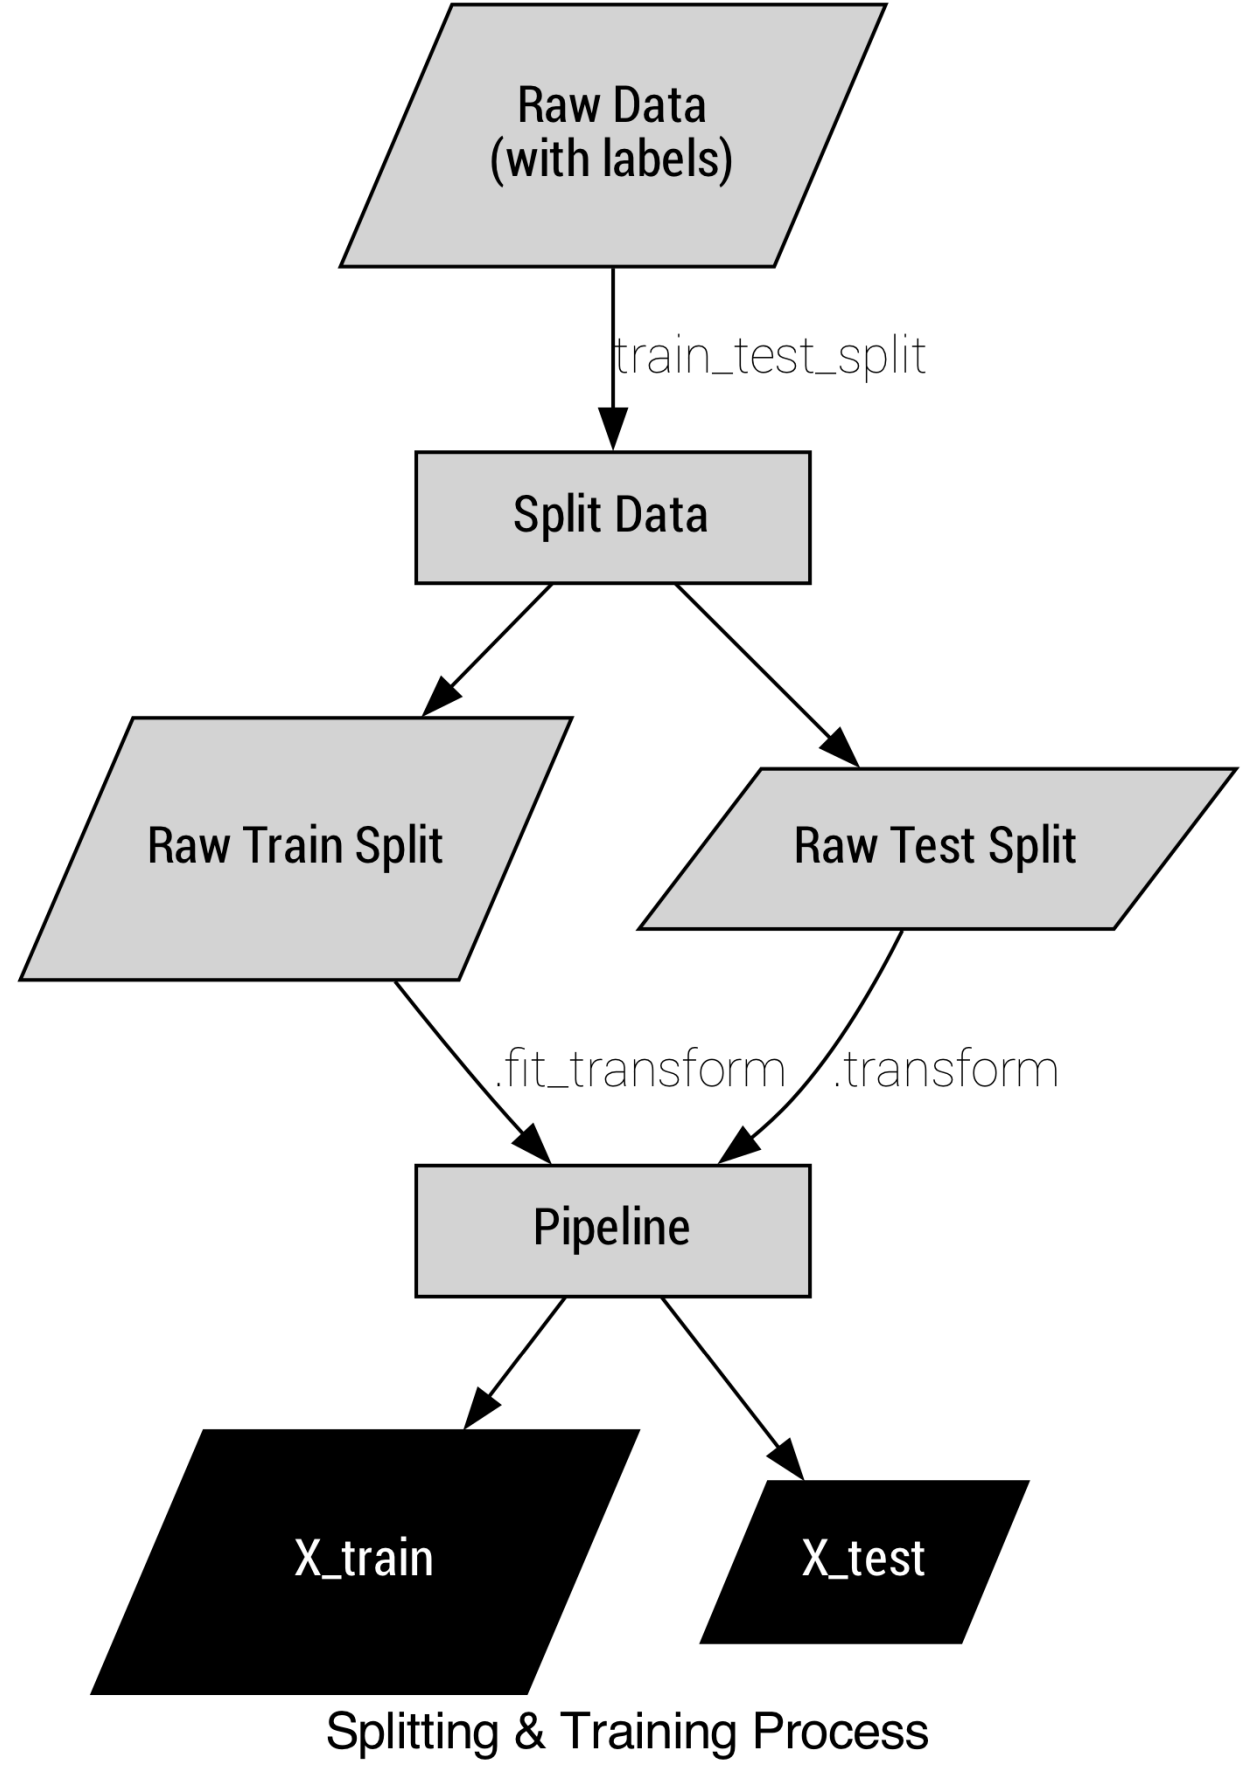